In [1]:
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import plotly.express as px

Seed = 999
torch.manual_seed(Seed)

In [2]:
# Chemin vers les images
dataroot = "img_align_celeba/"

# Batch size (combien d'image par combien)
batch_size = 128

# Taille voulue de l'image
image_size = 64

# Nombre de canaux (1 si greyscale 3 si rgb)
nc = 3

# Taille du vecteur bruit en entrée du générateur
nz = 100

# Taille de la feature map du générateur
ngf = 64

# Taille de la feature map du discriminateur
ndf = 64

# Nombre d'epochs
num_epochs = 10

# Learning rate (pas pour la descente de gradient)
lr = 0.0001

# Hyperparametres pour Adam
beta1 = 0.5
beta2 = 0.999
# Nombre de GPU disponible
ngpu = 1

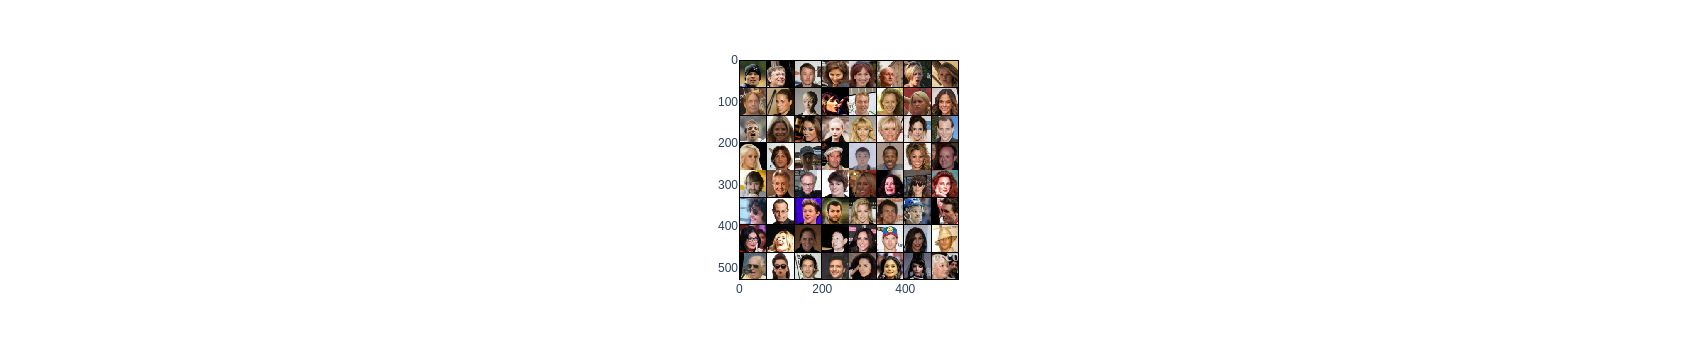

In [3]:
# Création du dataset
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                               transforms.Lambda(lambda x: torch.flatten(x))
                           ]))

# Dataloader pour utiliser le dataset
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=2)

# Choix du hardware pour les calcul (Si possible GPU)
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

#Vérification
real_batch = next(iter(dataloader))
px.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64].reshape(64,3,64,-1), padding=2, normalize=True).cpu(),(1,2,0)))

In [4]:
# Initialisation des poids
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [5]:
class Discriminator(torch.nn.Module):
    """
    A three hidden-layer discriminative neural network
    """
    def __init__(self,ngpu):
        super(Discriminator, self).__init__()
        self.ngpu=ngpu
        n_features = image_size*image_size*nc
        n_out = 1
        
        self.hidden0 = nn.Sequential( 
            nn.Linear(n_features, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.hidden1 = nn.Sequential(
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.out = nn.Sequential(
            torch.nn.Linear(256, n_out),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x

In [10]:
class Generator(torch.nn.Module):
    """
    A three hidden-layer generative neural network
    """
    def __init__(self,ngpu):
        super(Generator, self).__init__()
        self.ngpu=ngpu
        n_features = nz
        n_out = image_size*image_size*nc
        self.hidden0 = nn.Sequential(
            nn.Linear(n_features, 256),
            nn.LeakyReLU(0.2)
        )
        self.hidden1 = nn.Sequential(            
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2)
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2)
        )
        
        self.out = nn.Sequential(
            nn.Linear(1024, n_out),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x

In [22]:
# Création de l'instance du générateur
netG = Generator(ngpu).to(device)

# Initialisation des poids
netG.apply(weights_init)

# Print the model
print(netG)


# Création de l'instance du générateur
netD = Discriminator(ngpu).to(device)


# Initialisation des poids
netD.apply(weights_init)

# Print the model
print(netD)

Generator(
  (hidden0): Sequential(
    (0): Linear(in_features=100, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
  )
  (hidden1): Sequential(
    (0): Linear(in_features=256, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
  )
  (hidden2): Sequential(
    (0): Linear(in_features=512, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
  )
  (out): Sequential(
    (0): Linear(in_features=1024, out_features=12288, bias=True)
    (1): Tanh()
  )
)
Discriminator(
  (hidden0): Sequential(
    (0): Linear(in_features=12288, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3, inplace=False)
  )
  (hidden1): Sequential(
    (0): Linear(in_features=1024, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3, inplace=False)
  )
  (hidden2): Sequential(
    (0): Linear(in_features=512, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2)

In [23]:
# Fonction de perte (ici Binary Cross Entropy car deux classe réel et fake)
criterion = nn.BCELoss()

# Matrice de bruit fixée
fixed_noise = torch.randn(64, nz, device=device)
print(f'Fixed_noise {fixed_noise.shape}')

# Attribution des classe pour fake et réel
real_label = 1.
fake_label = 0.

# Initialisation des optimiseur
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, beta2))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, beta2))


Fixed_noise torch.Size([64, 100])


In [24]:
# Pour garder les informations
img_list = []
G_losses = []
D_losses = []

print("Starting Training Loop...")

for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):

        ############################
        # On entraine D
        ###########################
        ## Avec les données réelles
        netD.zero_grad()
        # On adapte le batch
        real_cpu = data[0].to(device)#->On met les données sur le bon hardware
        b_size = real_cpu.size(0)#->On récupére la taille du batch
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # On récupére la sortie du discriminateur
        output = netD(real_cpu).view(-1)
        # On calcule l'erreur de classification du discriminateur sur les données réelles
        errD_real = criterion(output, label)
        # On calcule la descente de gradient associé
        errD_real.backward()
        D_x = output.mean().item()

        ## Entrainement sur données simulée
        # On génére un batch de données simulées
        noise = torch.randn(b_size, nz, device=device)
        # On génére de fausse image depuis le générateur
        fake = netG(noise)
        label.fill_(fake_label)
        # On classifie le batch avec le discriminateur
        output = netD(fake.detach()).view(-1)
        # On calcule la perte du discriminateur
        errD_fake = criterion(output, label)
        # On calcule la descente de gradient associé
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # On calcule la perte de D
        errD = (errD_real + errD_fake)/2
        # On opère la descente de gradient
        optimizerD.step()

        ############################
        # On entraîne G
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # La perte de G est la perte de D si les images fake étaient vrai
        output = netD(fake).view(-1)
        # On calcule perte de G
        errG = criterion(output, label)
        # On calcule la descente de gradient associé
        errG.backward()
        D_G_z2 = output.mean().item()
        # On opère la descente de gradient associé
        optimizerG.step()

        # On print quelques infos
        if i % 500 == 0:
            print(f'[{epoch}/{num_epochs}][{i}/{len(dataloader)}]\tLoss_D: {errD.item()}\tLoss_G: {errG.item()}\tD(x): {D_x}\tD(G(z)): {D_G_z1} / {D_G_z2}')

        # On enregistre les loss
        G_losses.append(errG.item())
        D_losses.append(errD.item())

    #On enregiste un lot d'image par epoch
    with torch.no_grad():
        fake = netG(fixed_noise).detach().cpu()
        img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

Starting Training Loop...
[0/10][0/1583]	Loss_D: 0.6981830596923828	Loss_G: 0.6932012438774109	D(x): 0.49698907136917114	D(G(z)): 0.5019241571426392 / 0.4999774098396301
[0/10][500/1583]	Loss_D: 0.1424875259399414	Loss_G: 2.418114185333252	D(x): 0.9401149153709412	D(G(z)): 0.18736472725868225 / 0.10279794037342072
[0/10][1000/1583]	Loss_D: 0.3178648352622986	Loss_G: 4.015862464904785	D(x): 0.8876597881317139	D(G(z)): 0.3035803437232971 / 0.036811523139476776
[0/10][1500/1583]	Loss_D: 0.24885906279087067	Loss_G: 3.595402240753174	D(x): 0.8928282260894775	D(G(z)): 0.19512644410133362 / 0.07942184805870056
[1/10][0/1583]	Loss_D: 0.2652527689933777	Loss_G: 2.916064739227295	D(x): 0.8550111055374146	D(G(z)): 0.19513393938541412 / 0.09825605154037476
[1/10][500/1583]	Loss_D: 0.4187338948249817	Loss_G: 2.9240779876708984	D(x): 0.7941412925720215	D(G(z)): 0.32051682472229004 / 0.0996733084321022
[1/10][1000/1583]	Loss_D: 0.3779419958591461	Loss_G: 2.099018096923828	D(x): 0.7365542650222778	D(G

In [96]:
#Pour sauvegarder les images
for img, i in zip(img_list,range(10)):
    fig=px.imshow(np.transpose(vutils.make_grid(img.reshape(-1,3,64,64), padding=2, normalize=True)[:4].cpu(),(1,2,0))[:64*8+18,:64*8+18])
    fig.write_image(f"GAN/{i}.jpeg")